# MDAnalysis and Pilot-In-Memory


The main performance bottleneck of the current MDAnalysis implementation is the construction of the graph using NetworkX taking ~78% of the overall runtime.


**Beckstein Profiling:**

    47        10           33      3.3      0.0      if adj is None:
    48        10        66544   6654.4      0.0          x = atoms.positions

    54        10     58689221 5868922.1     18.8          adj = (MDAnalysis.core.parallel.distances.distance_array(x, x, box=box) < cutoff)
    
    58        10           78      7.8      0.0      adjk = adj if Nmax is None else adj[:Nmax, :Nmax] 
    59        10    243009076 24300907.6   77.9      graph = nx.Graph(adjk)
    60        10      4346636 434663.6      1.4      subgraphs = nx.connected_components(graph)
    61        49        83597   1706.1      0.0      indices = [np.sort(g) for g in subgraphs]
    62        49      5694698 116218.3      1.8      return [atoms[group].residues for group in indices]



## 1. LeafletFinder NetworkX Implementation Profiling

see https://code.google.com/p/mdanalysis/

Profile default implementation based on [NetworkX](https://networkx.github.io/)

In [1]:
FILENAME="../data/mdanalysis/small/graph_edges_95_215.csv"
!head -n 5 {FILENAME}

0,0
0,67
0,14
1,1
1,41


CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 8.11 µs


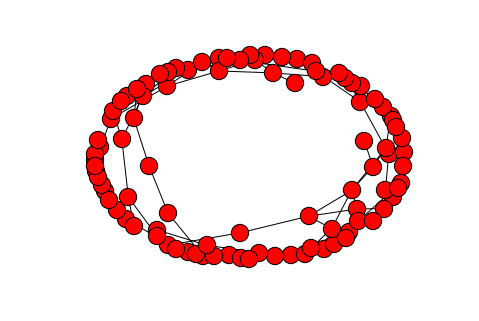

In [17]:
%matplotlib inline
%time
import networkx as NX
import time
import datetime
import sys

start = time.time()
nxg = NX.read_edgelist(FILENAME, delimiter=",")
end_read = time.time()
NX.draw(nxg, pos=NX.spring_layout(nxg))

Degree sequence [7, 7, 7, 7, 7, 7, 7, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2]
Length: 95


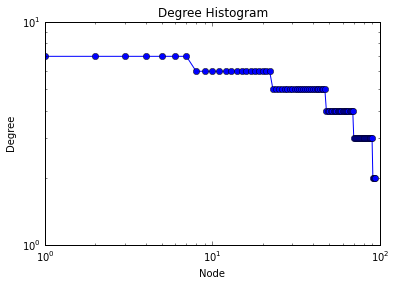

In [13]:
import matplotlib.pyplot as plt
degree_sequence=sorted(NX.degree(nxg).values(),reverse=True) # degree sequence
print "Degree sequence", degree_sequence
print "Length: %d" % len(degree_sequence)

dmax=max(degree_sequence)

plt.loglog(degree_sequence,'b-',marker='o')
plt.title("Degree Histogram")
plt.ylabel("Degree")
plt.xlabel("Node")

In [18]:
start = time.time()
components = NX.connected_components(nxg)
end_created = time.time()
count = 0
for component in components:
    print str(sorted(component))
    count = count + 1
end_connected = time.time()
print ("Number of Nodes: " + str(NX.number_of_nodes(nxg)))
print ("Number of Edges: " + str(NX.number_of_edges(nxg)))
print ("Connected Components: " + str(count))
print ("Runtime: " + str((end_connected-start)))
print ("Graph Creation Runtime: " + str((end_created-start)))
print ("Connected Components Runtime: " + str((end_connected - end_created)))

[u'0', u'13', u'14', u'2', u'24', u'25', u'26', u'29', u'34', u'37', u'48', u'49', u'5', u'52', u'57', u'6', u'61', u'62', u'64', u'65', u'67', u'70', u'79', u'86', u'89']
[u'1', u'12', u'19', u'22', u'23', u'27', u'3', u'30', u'33', u'38', u'39', u'4', u'41', u'44', u'50', u'51', u'54', u'59', u'66', u'68', u'7', u'72', u'87', u'9', u'91', u'94']
[u'11', u'17', u'20', u'28', u'42', u'46', u'55', u'58', u'60', u'69', u'73', u'75', u'8', u'81', u'85', u'88', u'90', u'93']
[u'21']
[u'56', u'76']
[u'32', u'35', u'36', u'43', u'45', u'47', u'53', u'63', u'74', u'77', u'78', u'80', u'82', u'84', u'92']
[u'83']
[u'10', u'16', u'31', u'40', u'71']
[u'15']
[u'18']
Number of Nodes: 95
Number of Edges: 215
Connected Components: 10
Runtime: 0.000545024871826
Graph Creation Runtime: 7.79628753662e-05
Connected Components Runtime: 0.00046706199646


In [ ]:
import os
from pilot_hadoop import PilotComputeService
from IPython.display import HTML

os.environ["SAGA_VERBOSE"]="100"

## 2. Pilot-Spark and Pilot-InMemory Implementation

Setup Spark cluster on local machine or HPC resource

### 2.1 Start Spark Cluster using Pilot-Spark

see https://github.com/drelu/saga-hadoop

In [1]:
pilot_compute_description = {
                            "resource_url":"fork://localhost",
                            "number_cores": 1,
                            "cores_per_node":1,
                            "type":"spark"
                            }
pilot = PilotComputeService.create_pilot(pilot_compute_description);

# print out details of Pilot-Spark
details = pilot.get_details()
HTML("<a target='blank' href='%s'>Spark Web UI</a>"%details["web_ui_url"])

Starting Spark bootstrap job...

**** Job: [fork://localhost]-[67675.0] State : Running
SPARK installation directory: /Users/luckow/workspace-saga/bigjob/Pilot-InMemory/jupyter/work/spark-1.3.0-bin-hadoop2.4
(please allow some time until the SPARK cluster is completely initialized)
export PATH=/Users/luckow/workspace-saga/bigjob/Pilot-InMemory/jupyter/work/spark-1.3.0-bin-hadoop2.4/bin:$PATH
Spark Web URL: http://10.180.17.197:8080
Create Spark Context for URL: spark://10.180.17.197:7077


Spark Web UI

### 2.2. Utilize Spark Native

In [2]:
sc = pilot.get_spark_context()
sc.version

rdd = sc.textFile("/path/to/leaflet_graph")

u'1.3.0'

### 2.3 Pilot-InMemory Implementation

In [1]:
du = DistributedInMemoryDataUnit(name="LeafletFinderGraph", sc=sc)

NameError: name 'DistributedInMemoryDataUnit' is not defined

In [7]:
from distributed_inmem.dataunit_spark import DistributedInMemoryDataUnit
import time

FILENAME="../data/mdanalysis/small/graph_edges_95_215.csv"

FILENAME_ALL_EDGES="../data/mdanalysis/small/graph_edges_95_215_alledges.csv"
du = DistributedInMemoryDataUnit(name="LeafletFinderGraph", sc=sc)

#DistributedInMemoryDataUnit.spark_context.version

f = open(FILENAME_ALL_EDGES)
graph = f.readlines()
du.load(graph)
f.close()

def identityMapper(edge, args):
    #print edge
    #comp = edge.strip().split(",")
    #return (int(comp[0]), int(comp[1]))
    return eval(str(edge))

def groupByVertex(data):
    print("Call reduce on: " + str(data))
    

new_iteration_needed = du.sc.accumulator(0)

# check for smaller keys in each set
def process_vertex(vertex):
    """ pass single vertex and its adjecent vertices
        e.g.: (0, [0, 67, 14])
    """
    global new_iteration_needed
    vertex = eval(vertex)
    source = int(vertex[0])
    dest= sorted([int(i) for i in vertex[1]])
    local_max = False
    
    first_edge_destination = int(dest[0])
    new_vertices = []    
    print "*********Source: %d First Edge Dest: %d"%(source, first_edge_destination) 
    if source <= first_edge_destination:
        local_max = True
        new_vertices.append((source, first_edge_destination))
            

    print "Process: " + str(vertex) + " Local Max: " + str(local_max)
    last_edge_destination = first_edge_destination

    for current_destination in vertex[1]:
        print "Current destination: %s"%str(current_destination)
        current_destination = int(current_destination)
        if current_destination == last_edge_destination: 
            continue
        
        if local_max == True:
            edge = (source, current_destination)
            new_vertices.append(edge)
        else:
            new_vertices.append((first_edge_destination, current_destination))
            new_vertices.append((current_destination, first_edge_destination))
            print "Add 1 to accumulator"
            new_iteration_needed.add(1)

        last_edge_destination = current_destination
    
    if ((not local_max) and (source < last_edge_destination)):
        new_vertices.append((source, first_edge_destination))
    
    print "Return new vertices: " + str(new_vertices)
    return new_vertices


#process_vertex("('19', ['19', '7', '9', '41'])")
num_iterations=0
start = time.time()
while True:
    old_accum_value = new_iteration_needed.value
    print "*********** Start iteration: %d " % num_iterations
    future_result = du.map_pilot(identityMapper, None, number_of_compute_units=2)
    result_du=future_result.result()[0]
    future_result = result_du.reduce_pilot(process_vertex, number_of_compute_units=2)
    output = future_result.result()
    output.export()   
    du = output
    num_iterations = num_iterations + 1
    print "New iteration accum: %d old value: %d"%(new_iteration_needed.value, old_accum_value)
    if old_accum_value < new_iteration_needed.value:
        #print "Accumulator value was increased. New iteration."
        continue        
        #pass
    else:
        break
    break
end = time.time()
print "Final results: "
num_components=du.data.groupByKey().count()
print "Finished after %d Iterations. Found %d components. Time: %.2f"%(num_iterations, num_components, (end-start))

*********** Start iteration: 0 
<function identityMapper at 0x10a9ad668>
[(0, 0), (0, 0), (0, 67), (67, 0), (0, 14), (14, 0), (1, 1), (1, 1), (1, 41), (41, 1), (2, 2), (2, 2), (2, 34), (34, 2), (2, 13), (13, 2), (2, 62), (62, 2), (3, 59), (59, 3), (3, 3), (3, 3), (3, 94), (94, 3), (3, 39), (39, 3), (4, 68), (68, 4), (4, 33), (33, 4), (4, 27), (27, 4), (4, 4), (4, 4), (4, 94), (94, 4), (5, 37), (37, 5), (5, 61), (61, 5), (5, 5), (5, 5), (5, 29), (29, 5), (6, 64), (64, 6), (6, 57), (57, 6), (6, 67), (67, 6), (6, 6), (6, 6), (7, 19), (19, 7), (7, 12), (12, 7), (7, 7), (7, 7), (8, 8), (8, 8), (8, 88), (88, 8), (8, 69), (69, 8), (8, 46), (46, 8), (8, 93), (93, 8), (9, 9), (9, 9), (9, 19), (19, 9), (9, 38), (38, 9), (9, 30), (30, 9), (9, 23), (23, 9), (10, 40), (40, 10), (10, 10), (10, 10), (10, 71), (71, 10), (10, 31), (31, 10), (11, 90), (90, 11), (11, 11), (11, 11), (11, 28), (28, 11), (11, 93), (93, 11), (11, 55), (55, 11), (12, 50), (50, 12), (12, 91), (91, 12), (12, 12), (12, 12), (12,

In [19]:
du.data.groupByKey().count()

10

### 2.3 Native Spark Implementation

In [2]:
#######################
# Mac OS:
# brew install apache-spark
# SPARK_HOME='/usr/local/Cellar/apache-spark/1.3.0/libexec/'
# Start Spark: /usr/local/Cellar/apache-spark/1.3.0/libexec/sbin/start-all.sh
# py4j needs be installed in your virtualenv
from pyspark import SparkContext, SparkConf, Accumulator, AccumulatorParam
from pyspark.sql import SQLContext
from pyspark.sql.types import *
from pyspark.mllib.linalg import Vector

try:
    sc
except NameError:
    sc = SparkContext("local[1]")
    sqlCtx=SQLContext(sc)

print "Loaded Spark: %s"%(sc.version)

ImportError: No module named pyspark

#### 2.3.1 Load data from text file 

In [17]:
%%time
data = sc.textFile(FILENAME).map(lambda line: [int(i) for i in line.split(",")])
# add backward edges
data = data.flatMap(lambda v: [(v[0],v[1]),(v[1],v[0])])

#data.saveAsTextFile("../data/mdanalysis/small/graph_edges_95_215_alledges.csv")
#data = data.filter(lambda v: v[0] != v[1])
#print data.collect()

data_grouped = data.groupByKey().mapValues(lambda a: sorted(set(a)))
print data_grouped.collect()

[(0, [0, 14, 67]), (2, [2, 13, 34, 62]), (4, [4, 27, 33, 68, 94]), (6, [6, 57, 64, 67]), (8, [8, 46, 69, 88, 93]), (10, [10, 31, 40, 71]), (12, [7, 12, 30, 50, 91]), (14, [0, 14, 48, 64]), (16, [16, 40]), (18, [18]), (20, [20, 85]), (22, [22, 54]), (24, [24, 62]), (26, [26, 49, 57, 70]), (28, [11, 17, 28, 69]), (30, [9, 12, 23, 30, 50]), (32, [32, 53]), (34, [2, 34]), (36, [36, 47, 84, 92]), (38, [9, 23, 38]), (40, [10, 16, 31, 40, 71]), (42, [42, 73]), (44, [44, 68]), (46, [8, 46]), (48, [14, 48, 49]), (50, [12, 23, 30, 50]), (52, [29, 52, 79, 89]), (54, [22, 54, 87]), (56, [56, 76]), (58, [58, 81]), (60, [17, 60, 69, 81]), (62, [2, 24, 25, 62, 79, 89]), (64, [6, 14, 57, 64, 67]), (66, [51, 66]), (68, [4, 44, 68, 72, 94]), (70, [26, 70, 79, 86]), (72, [68, 72]), (74, [43, 47, 53, 74, 82]), (76, [56, 76]), (78, [78, 92]), (80, [43, 80]), (82, [74, 77, 82]), (84, [36, 63, 84]), (86, [70, 79, 86]), (88, [8, 69, 88, 93]), (90, [11, 55, 75, 90]), (92, [36, 47, 78, 92]), (94, [3, 4, 33, 59,

#### 2.3.2 Connected Component Implementation

In [18]:
new_iteration_needed = sc.accumulator(0)
# check for smaller keys in each set
def process_vertex(vertex):
    """ pass single vertex and its adjecent vertices
        e.g.: (0, [0, 67, 14])
    """
    global new_iteration_needed
    source = vertex[0]
    local_max = False
    
    first_edge_destination = vertex[1][0]
    new_vertices = []    
    print "*********Source: %d First Edge Dest: %d"%(source, first_edge_destination) 
    if source <= first_edge_destination:
        local_max = True
        new_vertices.append((source, first_edge_destination))
            
    #pdb.set_trace()
    print "Process: " + str(vertex) + " Local Max: " + str(local_max)
    last_edge_destination = first_edge_destination

    #if vertex[1]==None or len(vertex[1])<=1:
    #    new_vertices.append((source, source))   
    for current_destination in vertex[1]:
        #print "Current destination: %s"%str(current_destination)
        if current_destination == last_edge_destination: 
            continue
        
        if local_max == True:
            edge = (source, current_destination)
            new_vertices.append(edge)
        else:
            new_vertices.append((first_edge_destination, current_destination))
            new_vertices.append((current_destination, first_edge_destination))
            print "Add 1 to accumulator"
            new_iteration_needed.add(1)

        last_edge_destination = current_destination
    
    if ((not local_max) and (source < last_edge_destination)):
        new_vertices.append((source, first_edge_destination))
    
    #print "Return new vertices: " + str(new_vertices)
    return new_vertices


#process_vertex((19, [7, 9, 19, 41]))
num_iterations=0
cc = data_grouped
start = time.time()
while True:
    old_accum_value = new_iteration_needed.value
    print "*********** Start iteration: %d " % num_iterations
    #print "Accum before iteration: " + str(old_accum_value)
    cc = cc.flatMap(lambda v: process_vertex(v))\
           .groupByKey()\
           .mapValues(lambda a: sorted(set(a)))
    cc.collect()
    num_iterations = num_iterations + 1
    #print "New iteration accum: %d old value: %d"%(new_iteration_needed.value, old_accum_value)
    if old_accum_value < new_iteration_needed.value:
        #print "Accumulator value was increased. New iteration."
        continue
    else:
        break
end = time.time()

print "Finished after %d Iterations. Found %d components. Time: %.2f"%(num_iterations, cc.count(), (end-start))

*********** Start iteration: 0 
*********** Start iteration: 1 
*********** Start iteration: 2 
*********** Start iteration: 3 
*********** Start iteration: 4 
*********** Start iteration: 5 
Finished after 6 Iterations. Found 10 components. Time: 0.42


## 3. Benchmark

---
## 4. Scratch Space

In [100]:
#start = df_grouped
result=start.flatMap(lambda v: (v[0], v[1])).map(lambda v: v<start_index).countByValue()

print sttrresult

local_max = not result.has_key(True)

print "Local Max: " + str(local_max) + " Smaller Index: " + str(result.has_key(True))

[0,
 [0, 67, 14],
 1,
 [1, 41],
 2,
 [2, 34, 13, 62],
 3,
 [59, 3, 94, 39],
 4,
 [68, 33, 27, 4, 94],
 5,
 [37, 61, 5, 29],
 6,
 [64, 57, 67, 6],
 7,
 [19, 12, 7],
 8,
 [8, 88, 69, 46, 93],
 9,
 [9, 19, 38, 30, 23],
 10,
 [40, 10, 71, 31],
 11,
 [90, 11, 28, 93, 55],
 12,
 [50, 91, 12, 30],
 13,
 [25, 13],
 14,
 [48, 14, 64],
 15,
 [15],
 16,
 [16, 40],
 17,
 [17, 28, 69, 60],
 18,
 [18],
 19,
 [19, 41],
 20,
 [20, 85],
 21,
 [21],
 22,
 [54, 22],
 23,
 [38, 50, 51, 23, 30],
 24,
 [24, 62],
 25,
 [25, 89, 62, 61],
 26,
 [49, 26, 70, 57],
 27,
 [33, 27],
 28,
 [28, 69],
 29,
 [65, 61, 52, 29],
 30,
 [50, 30],
 31,
 [40, 31],
 32,
 [32, 53],
 33,
 [33, 59, 91, 94],
 34,
 [34],
 35,
 [35, 45, 63],
 36,
 [92, 84, 36, 47],
 37,
 [37],
 38,
 [38],
 39,
 [87, 39],
 40,
 [40, 71],
 41,
 [41],
 42,
 [73, 42],
 43,
 [80, 74, 43, 47],
 44,
 [68, 44],
 45,
 [45],
 46,
 [46],
 47,
 [74, 47, 53, 92],
 48,
 [48, 49],
 49,
 [49],
 50,
 [50],
 51,
 [66, 51],
 52,
 [89, 52, 79],
 53,
 [74, 53],
 54,
 [5

In [6]:
schema = StructType([
            StructField("source", IntegerType(), True),
            StructField("destination", IntegerType(), True)
        ])
df = sqlCtx.createDataFrame(data, schema)
df.explain()
schema_grouped = StructType([
            StructField("source", IntegerType(), True),
            StructField("destination", ArrayType(IntegerType()), True)
        ])
df_grouped = sqlCtx.createDataFrame(data_grouped, schema_grouped)

PhysicalRDD [source#0,destination#1], MapPartitionsRDD[7] at mapPartitions at SQLContext.scala:1163



In [146]:
from pyspark.sql.functions import udf, lit
from pyspark.sql.functions import *
from pyspark.sql.types import ArrayType

t = udf(lambda s: str(s), StringType())
slen = udf(lambda s: Column(len(s)), IntegerType())

#df.groupBy("source").collect()
#df.groupBy("source").agg(df.source, t(df.source))

c = df.groupBy(df.source).agg(col("source"), slen(df.destination))

#c = df.agg(col("source"), t(df.destination).alias('counts'))
c.head(5)


#c = df.groupBy(df.source).lit(df.destination)

Py4JJavaError: An error occurred while calling o1427.agg.
: org.apache.spark.sql.AnalysisException: expression 'pythonUDF' is neither present in the group by, nor is it an aggregate function. Add to group by or wrap in first() if you don't care which value you get.;
	at org.apache.spark.sql.catalyst.analysis.CheckAnalysis.failAnalysis(CheckAnalysis.scala:37)
	at org.apache.spark.sql.catalyst.analysis.CheckAnalysis$$anonfun$apply$3.org$apache$spark$sql$catalyst$analysis$CheckAnalysis$$anonfun$$checkValidAggregateExpression$1(CheckAnalysis.scala:70)
	at org.apache.spark.sql.catalyst.analysis.CheckAnalysis$$anonfun$apply$3$$anonfun$apply$4.apply(CheckAnalysis.scala:86)
	at org.apache.spark.sql.catalyst.analysis.CheckAnalysis$$anonfun$apply$3$$anonfun$apply$4.apply(CheckAnalysis.scala:86)
	at scala.collection.immutable.List.foreach(List.scala:318)
	at org.apache.spark.sql.catalyst.analysis.CheckAnalysis$$anonfun$apply$3.apply(CheckAnalysis.scala:86)
	at org.apache.spark.sql.catalyst.analysis.CheckAnalysis$$anonfun$apply$3.apply(CheckAnalysis.scala:43)
	at org.apache.spark.sql.catalyst.trees.TreeNode.foreach(TreeNode.scala:78)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$foreachUp$1.apply(TreeNode.scala:87)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$foreachUp$1.apply(TreeNode.scala:87)
	at scala.collection.immutable.List.foreach(List.scala:318)
	at org.apache.spark.sql.catalyst.trees.TreeNode.foreachUp(TreeNode.scala:87)
	at org.apache.spark.sql.catalyst.analysis.CheckAnalysis.apply(CheckAnalysis.scala:43)
	at org.apache.spark.sql.SQLContext$QueryExecution.assertAnalyzed(SQLContext.scala:1069)
	at org.apache.spark.sql.DataFrame.<init>(DataFrame.scala:133)
	at org.apache.spark.sql.DataFrame$.apply(DataFrame.scala:51)
	at org.apache.spark.sql.GroupedData.agg(GroupedData.scala:165)
	at sun.reflect.GeneratedMethodAccessor67.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:483)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:231)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:379)
	at py4j.Gateway.invoke(Gateway.java:259)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:133)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:207)
	at java.lang.Thread.run(Thread.java:745)


In [88]:
vertices = df.select(df["source"]).unionAll(df.select(df["destination"]))
vertices = di_source.distinct()

print "Number of vertices: %d"%(vertices.count())

Number of vertices: 95


# GraphLab

In [ ]:
from graphlab import SGraph, SFrame
from graphlab import connected_components

PROBLEM={"small": "./data/mdanalysis/small/graph_edges_95_215.csv",
         "medium":"./data/mdanalysis/medium/graph_edges_24056_71826.csv"}

d =datetime.datetime.now()
RESULTSFILE = "results-" + d.strftime("%Y%m%d-%H%M%S") + ".csv"
REPEATS=5

start = time.time()
data = SFrame.read_csv(filename, header=False)
sg = SGraph().add_edges(data, src_field="X1", dst_field="X2")
end_read=time.time()
cc = connected_components.create(sg)
s=cc["component_size"]
end_connected = time.time()
print cc
print s